# Деревья решений, ансамбли и градиентные бустинги

Подготовил: Сабалевский Сергей

План:

1. Расскажу, что такое деревья решений, постараюсь кратко рассказать теорию, которая за ними стоит, быстро пробегусь по собственной реализации дерева решений.
2. Расскажу общую теорию ансамблей, посмотрим примеры ансемблей на основе линейной регрессии, деревьев решений. Рассмотрим:
 - бэггинг
 - бустинг (на примере адаптивного бустинга)
 - стэкинг
3. Перейдем рассмотрению градиентного бустинга на примере AdaBoost

Материала много, поэтому все подробно рассказывать не буду, если нужно остановиться на каком-то непонятном моменте - останавливайте

Презентация проводится с помощью расширения RISE для Jupyter Notebook

In [1]:
from sklearn import datasets as skdata # генерация примеров
from sklearn import tree as sktree     # реализация алгоритмов с деревьями решений
from sklearn import base as skbase     # базовые классы с реализацией API
from sklearn import utils as skutils   # полезные вспомогательные функции для модели
from sklearn import metrics as skmetrics

from pprint import pprint

from IPython.display import Image, display_svg, SVG
from dtreeviz.trees import dtreeviz

import scipy.optimize as sciopt
import numpy as np
import pandas as pd

import plotly.graph_objects as go      # визуализация
import plotly.subplots as subp         # для подграфиков

# Дерево решений

<img src="img/decision-tree-icon.png" width=400 height=400 alignment='center'/>

Деревья решений – это способ представления правил в иерархической, последовательной структуре, где каждому объекту соответствует единственный узел, дающий решение. Под правилом понимается логическая конструкция, представленная в виде "если ... то ...".

<img src="img/credit-example.jpeg" width=900 height=1200 />

## Область применения

Область применения деревьев решений в настоящее время широка, но все задачи могут быть разделены на следующие три класса:
* **Описание данных**: Деревья решений позволяют хранить информацию о данных в компактной форме, вместо них мы можем хранить дерево решений, которое содержит точное описание объектов.
* **Классификация**: Деревья решений отлично справляются с задачами классификации, т.е. отнесения объектов к одному из заранее известных классов. Целевая переменная должна иметь дискретные значения.
* **Регрессия**: Если целевая переменная имеет непрерывные значения, деревья решений позволяют установить зависимость целевой переменной от независимых(входных) переменных. 

## Алгоритм построения. Общий.

Пусть нам задано некоторое обучающее множество *T*, содержащее объекты (примеры), каждый из которых характеризуется *m* атрибутами (признаками), причем один из них указывает на принадлежность объекта к определенному классу.
Пусть через *{C$_{1}$, C$_{2}$, ... C$_{k}$}* обозначены классы(значения метки класса).

In [2]:
samples1, labels1 = skdata.make_classification(n_samples=1000,
                                               n_classes=3,
                                               n_clusters_per_class=1,
                                               scale=5.0,
                                               n_features=3,
                                               n_informative=3,
                                               n_redundant=0,
                                               n_repeated=0,
                                               class_sep=5.0,
                                               flip_y=0.0, # доля рандомно присвоенных меток
                                               random_state=42)
pprint(samples1[:10])
pprint(labels1[:10])

array([[ 25.91386014, -12.90567902,  19.89380468],
       [-24.72372841, -24.46276516,  23.09288229],
       [-29.72801096, -22.26695638,  19.28075562],
       [-21.64994794, -31.14217219, -27.15331807],
       [ 33.42835416, -17.86377023,  28.37627662],
       [-28.95843424, -21.0608913 , -28.47836755],
       [-31.11636869, -20.58306343,  15.72312575],
       [ 26.91116643, -22.19700094,  26.24299246],
       [ 26.4280968 , -21.26392472,  23.50210949],
       [-29.29910861, -20.82778043, -30.24610813]])
array([1, 0, 0, 2, 1, 2, 0, 1, 1, 2])


In [3]:
def draw_scatter3d(samples, labels, color=None):
    def create_trace(label, color=None):
        class_samples = samples[labels == label]
        cx, cy, cz = class_samples[..., 0], class_samples[..., 1], class_samples[..., 2]
        return go.Scatter3d(x=cx, y=cy, z=cz, mode="markers", marker=dict(size=8, color=color or label))
    return [create_trace(label, color) for label in np.unique(labels)]

In [4]:
trace = draw_scatter3d(samples1, labels1)
go.Figure(data=trace)

Тогда для множества *T* существует 3 ситуации:

1. множество *T* содержит один или более примеров, относящихся к одному классу *C$_{k}$*.

In [5]:
trace = draw_scatter3d(samples1, np.zeros_like(labels1) + 1)
go.Figure(data=trace)

Тогда дерево решений для Т – это лист, определяющий класс C$_{k}$;

2. множество *T* не содержит ни одного примера, т.е. пустое множество. 

In [6]:
trace = draw_scatter3d(samples1, np.zeros_like(labels1), color='white')
go.Figure(data=trace)

Тогда это снова лист, но уже пустой, и класс, ассоциированный с листом, выбирается из другого множества отличного от *T*, скажем, из множества, ассоциированного с родителем;

3. множество T содержит примеры, относящиеся к разным классам.

In [7]:
trace = draw_scatter3d(samples1, labels1)
go.Figure(data=trace)

В этом случае следует разбить множество T на подмножества таким образом, чтобы конечные подмножества содержали примеры, относящихся к одному и тому же классу.

Для этого выбирается один из признаков, имеющий два и более отличных друг от друга значений O$_{1}$, O$_{2}$, ... O$_{n}$. *T* разбивается на подмножества *T*$_{1}$, *T*$_{2}$, ... *T*$_{n}$, где каждое подмножество *T*$_{i}$ содержит все примеры, имеющие значение O$_{i}$ для выбранного признака. Это процедура будет рекурсивно продолжаться до тех пор, пока конечное множество не будет состоять из примеров, относящихся к одному и тому же классу.


In [8]:
def create_plain_3d(samples, along_axis='z', threshold=0.0):
    z_min, z_max = np.min(samples[..., 2]), np.max(samples[..., 2])
    y_min, y_max = np.min(samples[..., 1]), np.max(samples[..., 1])
    x_min, x_max = np.min(samples[..., 0]), np.max(samples[..., 0])

    if along_axis == 'x':
        return go.Surface(z=[[z_min, z_max], [z_min, z_max]],
                          x=[threshold, threshold],
                          y=[y_min, y_max],
                          showscale=False, showlegend=True)
    elif along_axis == 'y':
        return go.Surface(z=[[z_min, z_min], [z_max, z_max]],
                          x=[x_min, x_max],
                          y=[threshold, threshold],
                          showscale=False, showlegend=True)
    elif along_axis == 'z':
        return go.Surface(z=[[threshold, threshold], [threshold, threshold]],
                          x=[x_min, x_max],
                          y=[y_min, y_max],
                          showscale=False, showlegend=True)

In [9]:
dots_traces = draw_scatter3d(samples1, labels1)
go.Figure(data=dots_traces + [create_plain_3d(samples1, 'x'), create_plain_3d(samples1, 'z')])

In [10]:
np.stack([samples1[..., 0], labels1], axis=1)

array([[ 25.91386014,   1.        ],
       [-24.72372841,   0.        ],
       [-29.72801096,   0.        ],
       ...,
       [ 27.15534414,   1.        ],
       [ 22.87670506,   1.        ],
       [ 26.67856843,   1.        ]])

In [11]:
dfs = [pd.DataFrame(data=np.stack([samples1[..., i], labels1], axis=1)).groupby(1).agg([np.min, np.mean, np.max]) for i in range(3)]
pd.concat(dfs, axis=0, keys=['x', 'y', 'z']).T

x                                y                        \
1             0.0        1.0        2.0        0.0        1.0        2.0   
0 amin -38.320163  15.730393 -35.984614 -29.966612 -41.429922 -39.516417   
  mean -24.622631  24.885952 -25.285027 -25.170581 -24.510503 -24.778932   
  amax -14.033529  34.304298  -8.859694 -19.714557  -6.894233 -11.261192   

                z                        
1             0.0        1.0        2.0  
0 amin  11.077412  15.883159 -41.384539  
  mean  25.278902  24.534073 -25.234872  
  amax  37.872779  34.311708  -8.272729

Вышеописанная процедура лежит в основе многих современных алгоритмов построения деревьев решений, этот метод известен еще под названием “разделяй и властвуй” (divide and conquer). Очевидно, что при использовании данной методики, построение дерева решений будет происходит сверху вниз.

На сегодняшний день существует значительное число алгоритмов, реализующих деревья решений ID3, C4.5, CART, CHAID и т.д. Но наибольшее распространение и популярность получили следующие два:
* CART (Classification and Regression Tree) – это алгоритм построения бинарного дерева решений – дихотомической классификационной модели. Каждый узел дерева при разбиении имеет только двух потомков. Как видно из названия алгоритма, решает задачи классификации и регрессии.
* C4.5 – алгоритм построения дерева решений, количество потомков у узла не ограничено. Не умеет работать с непрерывным целевым полем, поэтому решает только задачи классификации.

## Этапы построения дерева решений

При построении деревьев решений особое внимание уделяется следующим вопросам: выбору критерия атрибута, по которому пойдет разбиение, остановки обучения и отсечения ветвей. Рассмотрим все эти вопросы по порядку.

### Правило разбиения. Как сделать "правильное" разбиение?

Для построения дерева на каждом внутреннем узле необходимо найти такое условие (проверку), которое бы разбивало множество, ассоциированное с этим узлом на подмножества. В качестве такой проверки должен быть выбран один из атрибутов. Общее правило для выбора атрибута можно сформулировать следующим образом: выбранный атрибут должен разбить множество так, чтобы получаемые в итоге подмножества состояли из объектов, принадлежащих к одному классу, или были максимально приближены к этому, т.е. количество объектов из других классов ("примесей") в каждом из этих множеств было как можно меньше.

#### Энтропия. Entropy.

В общем, каждое разбиение должно разделять данные на две наиболее "чистые" группы.

Будем использовать понятие "чистые" группы следующим образом:
 - Если все точки в группе одного класса, то это "чистая" группа. 
 - Если же у вас в группе присутсвуют точки разных классов, то это "нечистая" группа.
 
Способ измерения чистоты - вычисление энтропии данных.

***Entropy*** $H(X) = -\sum^{n}_{i=1}p(x_{i})\log_{2}p(x_{i})$, где  
$X$ – случайное число(в нашем случае объект из множества), которое может принимать значения $x_{1},...,x_{n}$,  
$n$ – количество классов (значений случайного числа $X$),  
$p(x_{i})$ – верояность принадлежности объекта к классу $x_{i}$.

In [12]:
def entropy(labels_set):
    ulabels, counts = np.unique(labels_set, return_counts=True)
    probabilities = counts/len(labels_set)
    return np.sum([-probability*np.log2(probability) for probability in probabilities])

#### Критерий прироста информации. Информационный выигрыш.

На практике чаще всего в вычислениях используют не саму энтропию, а так называемый **критерий прироста информации**.  

Он задается следующим образом:  
$IG(T,a) = H(T) - H(T|a)$, где   
$H(T)$ – энтропия родителя (изначального множества),   
$H(T|a)$ – взвешенная сумма энтропии наследников, после разделения критерием $a$.

In [13]:
def infogain(labels_set, criteria):
    parent_entropy = entropy(labels_set)
    
    right_child = labels_set[criteria]
    left_child = labels_set[np.invert(criteria)]
    
    right_weight = len(right_child)/len(labels_set)
    left_weight = len(left_child)/len(labels_set)
    
    childs_entropy = right_weight * entropy(right_child) + left_weight * entropy(left_child)
    
    return parent_entropy - childs_entropy

#### Критерий Джини. Gini impurity.

Критерий Джини является мерой, насколько часто случайно выбранный элемент из набора неверно помечается, если он случайным образом помечается согласно распределению меток в подмножестве.   

Критерий Джини может быть вычислен путём суммирования вероятности $p_i$ элемента с выбранной меткой $i$, умноженной на $\sum_{k\neq i}p_k=1-p_i$ – вероятность ошибки категоризации этого элемента. Критерий принимает минимум (ноль), когда все элементы в наборе попадают в одну целевую категорию.   

Для вычисления критерия Джини для набора элементов с $N$ классами, предположим, что $i \in \{1,2,...,N\}$, и пусть $p_i$ будет долей элементов, помеченных классом $i$ в наборе.   

$\scriptsize Gini(p)=\sum^N_{i=1}p_i\sum_{k\neq i}p_k=\sum^N_{i=1}p_i(1-p_i)=\sum^N_{i=1}(p_i-p_i^2)=\sum^N_{i=1}p_i-\sum^N_{i=1}p_i^2=1-\sum^N_{i=1}p_i^2$

На практике чаще всего в вычислениях используют **критерий Джини для разбиения**, он очень похож на критерий прироста информации:   

$Gini_{gain}(p,a) = Gini(p) - Gini_{split}(p|a)$, где   
$Gini(p)$ – критерий Джини родителя (изначального множества),   
$Gini_{split}(p|a)$ – взвешенная сумма критериев Джини наследников, после разбиения атрибутом $a$.

In [14]:
def gini(labels_set):
    ulabels, counts = np.unique(labels_set, return_counts=True)
    probabilities = counts/len(labels_set)
    return 1 - np.sum(np.square(probabilities))

def ginisplit(labels_set, criteria):
    right_child = labels_set[criteria]
    left_child = labels_set[np.invert(criteria)]
    right_weight = len(right_child)/len(labels_set)
    left_weight = len(left_child)/len(labels_set)
    
    childs_gini = right_weight * gini(right_child) + left_weight * gini(left_child)
    return childs_gini

def ginigain(labels_set, criteria):
    parent_gini = gini(labels_set)
    childs_gini = ginisplit(labels_set, criteria)
    return parent_gini - childs_gini

In [15]:
def draw_scatter(samples, labels):
    def create_trace(label):
        class_samples = samples[labels == label]
        cx, cy = class_samples[..., 0], class_samples[..., 1]
        return go.Scatter(x=cx, y=cy, mode="markers", marker=dict(size=8))
    return [create_trace(label) for label in np.unique(labels)]


first_group, first_group_labels = skdata.make_classification(n_samples=1000,
                                                             n_classes=3,
                                                             n_clusters_per_class=1,
                                                             scale=1.0,
                                                             n_features=2,
                                                             n_informative=2,
                                                             n_redundant=0,
                                                             n_repeated=0,
                                                             class_sep=5.0,
                                                             flip_y=0.0,
                                                             random_state=42)

second_group, second_group_labels = skdata.make_classification(n_samples=1000,
                                                               n_classes=1,
                                                               n_clusters_per_class=1,
                                                               scale=1.0,
                                                               n_features=2,
                                                               n_informative=2,
                                                               n_redundant=0,
                                                               n_repeated=0,
                                                               class_sep=5.0,
                                                               flip_y=0.0,
                                                               random_state=42)

first_group[:5], first_group_labels[:5]

(array([[-4.52487717, -3.96271364],
        [-4.69270703, -2.88442398],
        [-4.23821546, -4.22807905],
        [ 4.52346462,  5.08200909],
        [-4.95470053, -3.34533289]]),
 array([2, 2, 2, 1, 2]))

In [16]:
trace1 = draw_scatter(first_group, first_group_labels)
trace2 = draw_scatter(second_group, second_group_labels)
traces = trace1 + trace2

fig = subp.make_subplots(rows=1,
                         cols=2,
                         subplot_titles=("Group 1", "Group 2"))
fig.add_traces(data=traces,
               rows=[1, 1, 1, 1],
               cols=[1, 1, 1, 2])

In [17]:
fig.update_layout(dict(autosize=False,
                       width=600,
                       height=300))

In [18]:
# Давайте посчитаем энтропию для этих двух групп:

print(f"Группа 1: {entropy(first_group_labels)}")
print(f"Группа 2: {entropy(second_group_labels)}")
print(f"Энтропия разбиения: {(1000/2000)*entropy(first_group_labels) + (1000/2000)*entropy(second_group_labels)}")

Группа 1: 1.584961058506293
Группа 2: 0.0
Энтропия разбиения: 0.7924805292531465


In [19]:
# Давайте посчитаем критерий Джинни для этих двух групп:

print(f"Группа 1: {gini(first_group_labels)}")
print(f"Группа 2: {gini(second_group_labels)}")
print(f"Критерий Джини разбиения: {(1000/2000)*gini(first_group_labels) + (1000/2000)*gini(second_group_labels)}")

Группа 1: 0.666666
Группа 2: 0.0
Критерий Джини разбиения: 0.333333


In [20]:
samples2, labels2 = skdata.make_classification(n_samples=1000, 
                                               n_classes=3,
                                               n_clusters_per_class=1,
                                               scale=1.0, 
                                               n_features=2, 
                                               n_informative=2, 
                                               n_redundant=0, 
                                               n_repeated=0,
                                               class_sep=5.0,
                                               flip_y=0.0,
                                               random_state=42)

In [21]:
trace = draw_scatter(samples2, labels2)
go.Figure(data=trace)

In [22]:
def optimal_feature_split(labels_set, feature):
    feature_uvalues = np.unique(feature)
    gain_scores = [ginigain(labels_set, feature <= value)
                   for value in feature_uvalues]
    index_max = np.argmax(gain_scores)
    return feature_uvalues[index_max], gain_scores[index_max]


def find_optimal_split(values_set, labels_set):
    features = np.squeeze(np.split(values_set, values_set.shape[1], axis=1))
    split_score = np.array([optimal_feature_split(labels_set, feature)
                            for feature in features])

    optimal_feature = np.argmax(split_score[..., 1])
    optimal_value, gain_score = split_score[optimal_feature]
    return optimal_feature, optimal_value, gain_score

In [23]:
feature_id, criteria, metric = find_optimal_split(samples2, labels2)
feature_id, criteria, metric

(0, -3.6777265401775594, 0.33316674962518733)

In [24]:
def make_split(values_set, labels_set, feature_id, criteria):
    mask = values_set[...,feature_id] <= criteria
    mask_inv = np.invert(mask)
    
    right_child_values = values_set[mask]
    right_child_labels = labels_set[mask]
    left_child_values = values_set[mask_inv]
    left_child_labels = labels_set[mask_inv]
    
    return right_child_values, left_child_values, right_child_labels, left_child_labels

In [25]:
g1_samples, g2_samples, g1_labels, g2_labels = make_split(samples2, labels2, feature_id, criteria)
print(np.unique(g1_labels, return_counts=True))
print(np.unique(g2_labels, return_counts=True))

(array([2]), array([333], dtype=int64))
(array([0, 1]), array([334, 333], dtype=int64))


In [26]:
def create_line_2d(samples, along_axis, threshold=0.0):
    x_range = [np.min(samples[...,0]), np.max(samples[...,0])]
    y_range = [np.min(samples[...,1]), np.max(samples[...,1])]
    split_range = [threshold,threshold]

    if along_axis == 0:
        split_trace = go.Scatter(x=split_range, y=y_range, mode="lines")
    elif along_axis == 1:
        split_trace = go.Scatter(x=x_range, y=split_range, mode="lines")
    return split_trace

In [27]:
split_trace = create_line_2d(samples2, feature_id, criteria)
go.Figure(data=trace+[split_trace])

In [28]:
go.Figure(data=trace+[split_trace],layout=go.Layout(autosize=False, width=800, height=400))

In [29]:
print(f"Критерий Джини для исходного множества (классов: {len(np.unique(labels2))}): {gini(labels2)}")
print(f"Критерий Джини для группы 1 (классов: {len(np.unique(g1_labels))}): {gini(g1_labels)}")
print(f"Критерий Джини для группы 2 (классов: {len(np.unique(g2_labels))}): {gini(g2_labels)}")

Критерий Джини для исходного множества (классов: 3): 0.666666
Критерий Джини для группы 1 (классов: 1): 0.0
Критерий Джини для группы 2 (классов: 2): 0.49999887612415683


### Генерация дерева для классификации. CART

In [30]:
class DecisionTreeClassifier(skbase.BaseEstimator, skbase.ClassifierMixin):

    def __init__(self, criterion="gini"):
        self.criterion = criterion
        self.is_fitted_ = False
        self.classes_ = None
    
    def fit(self, X, y):
        X, y = skutils.validation.check_X_y(X, y)
        
        self.classes_ = skutils.multiclass.unique_labels(y)
        self.is_fitted_ = True
        
        return self
    
    def predict(self, X):
        skutils.validation.check_is_fitted(self)
        
        X = skutils.validation.check_array(X)
        
        predicted_classes = np.ones(X.shape[0],dtype=X.dtype)
        return predicted_classes

In [31]:
def entropy(labels_set):
    ulabels, counts = np.unique(labels_set, return_counts=True)
    probabilities = counts/len(labels_set)
    return np.sum([-probability*np.log2(probability) for probability in probabilities])

def gini(labels_set):
    ulabels, counts = np.unique(labels_set, return_counts=True)
    probabilities = counts/len(labels_set)
    return 1 - np.sum(np.square(probabilities))

In [32]:
def childs_criteria_gain(labels_set, group_mask, criteria):
    right_child = labels_set[group_mask]
    left_child = labels_set[np.invert(group_mask)]
    
    right_weight = len(right_child)/len(labels_set)
    left_weight = len(left_child)/len(labels_set)
    
    childs_criteria = right_weight * criteria(right_child) + left_weight * criteria(left_child)
    return childs_criteria

def gain(labels_set, group_mask, criteria):
    parent_criteria = criteria(labels_set)
    childs_criteria = childs_criteria_gain(labels_set, group_mask, criteria)
    return parent_criteria - childs_criteria

In [33]:
def optimal_feature_split(labels_set, feature, criteria):
    feature_uvalues = np.unique(feature)
    gain_scores = [gain(labels_set, feature <= value, criteria) for value in feature_uvalues]
    index_max = np.argmax(gain_scores)
    return feature_uvalues[index_max], gain_scores[index_max]

def find_optimal_split(values_set, labels_set, criteria):
    features = np.squeeze(np.split(values_set,values_set.shape[1], axis=1))
    split_score = np.array([optimal_feature_split(labels_set, feature, criteria) 
                            for feature in features])
    
    optimal_feature = np.argmax(split_score[...,1])
    optimal_value, gain_score = split_score[optimal_feature]
    return optimal_feature, optimal_value, gain_score

def make_split(values_set, labels_set, feature_id, feature_value):
    mask = values_set[...,feature_id] <= feature_value
    mask_inv = np.invert(mask)
    
    right_child_values = values_set[mask]
    right_child_labels = labels_set[mask]
    left_child_values = values_set[mask_inv]
    left_child_labels = labels_set[mask_inv]
    
    return right_child_values, left_child_values, right_child_labels, left_child_labels

In [34]:
def build_tree(samples, labels, criteria):
    current_set_criteria = criteria(labels)
    if current_set_criteria == 0.0:
        return np.unique(labels)[0]
    
    feature_id, feature_value, metric = find_optimal_split(samples, labels, criteria)
    right_samples, left_samples, right_labels, left_labels = make_split(samples, labels, feature_id, feature_value)
    
    tree = dict()
    tree["feature_id"] = feature_id 
    tree["feature_value"] = feature_value
    tree[criteria.__name__] = current_set_criteria
    tree[f"{criteria.__name__}_metric_split"] = metric
    
    tree["right"] = build_tree(right_samples, right_labels, criteria)
    tree["left"] = build_tree(left_samples, left_labels, criteria)
    
    return tree

In [35]:
from pprint import pprint
dtree_set2 = build_tree(samples2, labels2, gini)
pprint(dtree_set2)

{'feature_id': 0,
 'feature_value': -3.6777265401775594,
 'gini': 0.666666,
 'gini_metric_split': 0.33316674962518733,
 'left': {'feature_id': 1,
          'feature_value': -2.7806342681298037,
          'gini': 0.49999887612415683,
          'gini_metric_split': 0.49999887612415683,
          'left': 1,
          'right': 0},
 'right': 2}


In [36]:
def get_line_sep(samples, tree):
    line_traces = [create_line_2d(samples, tree["feature_id"],tree["feature_value"])]
    if isinstance(tree["right"], dict):
        line_traces.extend(get_line_sep(samples, tree["right"]))
    if isinstance(tree["left"], dict):
        line_traces.extend(get_line_sep(samples, tree["left"]))
    return line_traces
    
sep_lines_traces = get_line_sep(samples2, dtree_set2)

go.Figure(data=trace+sep_lines_traces)

In [37]:
def predict(tree, X):
    if X[tree['feature_id']] <= tree['feature_value']:
        if isinstance(tree['right'], dict):
            return predict(tree['right'], X)
        else:
            return tree['right']
    else:
        if isinstance(tree['left'], dict):
            return predict(tree['left'], X)
        else:
            return tree['left']


In [38]:
print(f"X:{samples2[0]}, Y:{labels2[0]}")
print(f"Prediction: {predict(dtree_set2, samples2[0])}")

X:[-4.52487717 -3.96271364], Y:2
Prediction: 2


In [39]:
class DecisionTreeClassifier(skbase.BaseEstimator, skbase.ClassifierMixin):

    def __init__(self, criterion="gini"):
        if criterion == "gini":
            self.criterion = gini
        elif criterion == "entropy":
            self.criterion = entropy
        else:
            raise NotImplementedError(f"{criterion} not implemented.")
        self.is_fitted_ = False
        self.classes_ = None
        self.tree_ = None
    
    def fit(self, X, y):
        X, y = skutils.validation.check_X_y(X, y)
        
        self.classes_ = skutils.multiclass.unique_labels(y)
        self.is_fitted_ = True
        
        self.tree_ = build_tree(X,y,self.criterion)
        
        return self
    
    def predict(self, X):
        skutils.validation.check_is_fitted(self)
        
        X = skutils.validation.check_array(X)
        
        predicted_classes = [predict(self.tree_, sample) for sample in X]
        
        return predicted_classes

In [40]:
class_model = DecisionTreeClassifier(criterion="gini").fit(samples2, labels2)
predicted_values = class_model.predict(samples2[0:10])
real_values = labels2[0:10]
pd.DataFrame(data=dict(predicted_values=predicted_values, real_values=real_values))

predicted_values  real_values
0                 2            2
1                 2            2
2                 2            2
3                 1            1
4                 2            2
5                 0            0
6                 0            0
7                 2            2
8                 1            1
9                 0            0

### Генерация дерева для регрессии. CART (Again)

Если при классификации в листах стоят результирующие классы, при регрессии же стоит какое-то значение целевой функции. Для построения можно использовать тот же алгоритм CART.

<img src="img/regression_tree.png" width=900 height=900/>

<img src="img/regression_tree.png" width=700 height=700 />

На выше приведенном изображении регрессионное дерево, для определения цены на землю в городе Бостон в 1978 году, в зависимости от параметров RM — количество комнат, LSTAT — процент неимущих и нескольких других параметров.   

Соответственно, здесь в каждом узле мы видим **среднее значение (Avg)** и **стандартное отклонение (STD)** значений целевой функции наблюдений попавших в эту вершину. Общее количество наблюдений попавших в узел N. Результатом регрессии будет то значение среднего (Avg), в какой узел попадёт наблюдение.
Таким образом изначально классификационное дерево, может работать и для регрессии.

### Правило остановки

В дополнение к основному методу построения деревьев решений были предложены следующие правила:
1. Использование статистических методов для оценки целесообразности дальнейшего
разбиения, так называемая "ранняя остановка" (prepruning). В конечном счете "ранняя
остановка" процесса построения привлекательна в плане экономии времени обучения,
но здесь уместно сделать одно важное предостережение: этот подход строит менее
точные классификационные модели и поэтому ранняя остановка крайне
нежелательна. Признанные авторитеты в этой области Л.Брейман и Р. Куинлен
советуют буквально следующее: "Вместо остановки используйте отсечение».
2. Ограничить глубину дерева. Остановить дальнейшее построение, если разбиение
ведет к дереву с глубиной превышающей заданное значение.
3. Разбиение должно быть нетривиальным, т.е. получившиеся в результате узлы должны
содержать не менее заданного количества примеров.
Этот список эвристических правил можно продолжить, но на сегодняшний день не
существует такого, которое бы имело большую практическую ценность. К этому вопросу
следует подходить осторожно, так как многие из них применимы в каких-то частных
случаях

### Правила отсечения

Очень часто алгоритмы построения деревьев решений дают сложные деревья, которые
"переполнены данными", имеют много узлов и ветвей. Такие "ветвистые" деревья очень
трудно понять. К тому же ветвистое дерево, имеющее много узлов, разбивает обучающее
множество на все большее количество подмножеств, состоящих из все меньшего
количества объектов.
Ценность правила, справедливого скажем для 2-3 объектов, крайне низка, и в целях
анализа данных такое правило практически непригодно. Гораздо предпочтительнее иметь
дерево, состоящее из малого количества узлов, которым бы соответствовало большое
количество объектов из обучающей выборки.

Пусть под точностью (распознавания) дерева решений понимается отношение правильно
классифицированных объектов при обучении к общему количеству объектов из
обучающего множества, а под ошибкой – количество неправильно классифицированных.
Предположим, что нам известен способ оценки ошибки дерева, ветвей и листьев. Тогда,
возможно использовать следующее простое правило:
1. построить дерево;
2. отсечь или заменить поддеревом те ветви, которые не приведут к возрастанию ошибки.

В отличии от процесса построения, отсечение ветвей происходит снизу вверх, двигаясь с
листьев дерева, отмечая узлы как листья, либо заменяя их поддеревом.
Хотя отсечение не является панацеей, но в большинстве практических задач дает
хорошие результаты, что позволяет говорить о правомерности использования подобной
методики.

## Что там у sklearn?

[Text(133.92000000000002, 181.2, 'X[0] <= -1.075\ngini = 0.667\nsamples = 1000\nvalue = [334, 333, 333]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 333\nvalue = [0, 0, 333]'),
 Text(200.88000000000002, 108.72, 'X[1] <= 0.013\ngini = 0.5\nsamples = 667\nvalue = [334, 333, 0]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 334\nvalue = [334, 0, 0]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.0\nsamples = 333\nvalue = [0, 333, 0]')]

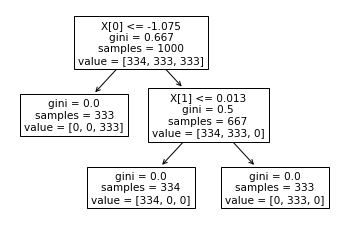

In [41]:
model = sktree.DecisionTreeClassifier(criterion='gini').fit(samples2, labels2)
sktree.plot_tree(model)

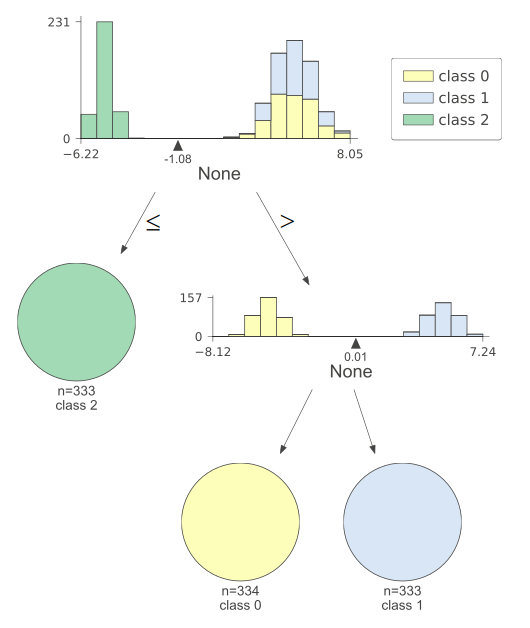

In [42]:
viz = dtreeviz(model,
               samples2,
               labels2,
               scale=2.0,
              )
              
viz

## Ансамбли

При решении большинства задач регрессии и классификации, оказывается, что один алгоритм не обсепечивает желаемого качества востановления функцилональной зависимости. Тогда стоит строить композицию алгоритмов называемую ансамблем, в которых ошибки отдельных алгоритмов компенсируются.

Мы все также будем рассматривать задачу обучения по прецедентам:
- **$\chi$** — пространство объектов
- $Y$ — пространство ответов
- $x = (x^1, ..., x^d)$ — признаковое описание объекта
- X = $(x_i, y_i)^{n}_{i=1}$ — обучающая выборка
- $a(x)$ — алгоритм, модель
- $Q(a,$ X$)$ — функционал ошибки алгоритма a на выборке X
- Обучение: $a(x) = argmin_{a∈A} Q(a, $X$)$

Для введения в постановку задачи композиции следует добавить следующее:


*   $R$ - пространство оценок
*   $b : \chi → R$ - алгоритмический оператор
*   $C : R → Y$ - решающее правило

Теперь наш алгоритм $a(x)$ может быть задан как $a(x) = C(b(x))$. 

В качестве примера можно вспомнить линейный классификатор для бинарной классифкации. \
Итак $Y = \{-1, 1\}$, а наш алгоритм $a(x) = sign(\langle w,x\rangle)$. \
Таким образом мы можем представить его в виде композиции:
- $b(x) = \langle w,x\rangle$ - расстояние до разделяющей гиперплоскости
- $C(b(x)) = sign(b(x))$ - решающее правило

Композия $T$ алгоритмов $a_t(x) = C(b_t(x)),  t=1...T$ \
представляет собой суперпозицию алгоритмических операторов $b_t: X → R$,\
 корректирующей функции $F: R^T → R$ и решающего правила $C : R → Y$.

 $a(x)=C(F(b_1(x), ... , b_T(x)))$

 
Алгоритмы $a_t$, а иногда и операторы $b_t$, называют базовыми алгоритмами.

В задаче регрессии у нас $Y$ это непрерывная переменная $Y = R$.\
Значит решающее правило в задаче регрессии будет $C(b) = b$.\
Таким образом можно построить ансамбль и для регресиии.

In [43]:
X, y = skdata.make_classification(n_samples=2000,
                                  n_classes=4,
                                  n_clusters_per_class=1,
                                  scale=5.0,
                                  n_features=2,
                                  n_informative=2,
                                  n_redundant=0,
                                  n_repeated=0,
                                  class_sep=5.0,
                                  flip_y=0.0,
                                  random_state=42)
X[:10], y[:10]

(array([[-28.41894279, -26.34372737],
        [ 32.82103676, -21.70503927],
        [-24.96052472,  23.65790496],
        [ 24.51172347, -24.4536073 ],
        [ 25.19583933,  32.74482892],
        [ 25.09774143, -19.52537215],
        [-25.60467331,  25.20897231],
        [ 17.76501874,  33.28420955],
        [-26.79752471,  30.87166188],
        [-25.86608425,  27.89836917]]),
 array([0, 2, 1, 2, 3, 2, 1, 3, 1, 1]))

In [44]:
def draw_scatter3d(samples, labels):
    def create_trace(label):
        class_samples, class_labels = samples[labels==label], labels[labels==label]
        cx, cy = class_samples[...,0], class_samples[...,1],
        return go.Scatter3d(x=cx, y=cy, z=class_labels, mode="markers", marker=dict(size=4), name=f'{label}')
    return [create_trace(label) for label in np.unique(labels)]

    return scatter_trace
traces = draw_scatter3d(X, y)
go.Figure(data=traces)

In [45]:
def add_fictive_feature(X):
    smaple_number, _ = X.shape
    x0 = np.full(smaple_number, 1)
    return np.vstack([x0, X.T]).T


def classification_quality(weights, X, y, sample_weights):
    return np.sum(sample_weights*np.log(1+np.exp(-y*(X@weights))))


def binary_classififcation_train(X, y, weights=None, sample_weights=None):
    X = add_fictive_feature(X)
    samples_number, feature_number = X.shape
    if sample_weights is None:
        sample_weights = np.full(samples_number, 1/samples_number)
    if weights is None:
        weights = np.full(feature_number, 0)
    return sciopt.minimize(classification_quality, weights, args=(X, y, sample_weights)).x


def binary_classififcation_distance(X, weights):
    return add_fictive_feature(X)@weights

In [46]:
class BaseLinearClassification(skbase.BaseEstimator, skbase.ClassifierMixin):
    def __init__(self, weights=None):
        self.is_fitted_ = False
        self.classes_ = None
        self.weights = weights

    def fit(self, X, y, sample_weights=None):
        X, y = skutils.validation.check_X_y(X, y)

        self.classes_ = skutils.multiclass.unique_labels(y)
        self.weights = binary_classififcation_train(
            X, y, self.weights, sample_weights)
        self.is_fitted_ = True

        return self

    def predict(self, X):
        skutils.validation.check_is_fitted(self)

        X = skutils.validation.check_array(X)

        distances = binary_classififcation_distance(X, self.weights)

        return np.sign(distances)

In [47]:
example_X, example_y = X.copy(), y.copy()
example_y = ((y == 0)-0.5)*2

model = BaseLinearClassification()
model.fit(example_X, example_y)
y_pred = model.predict(example_X)
print(skmetrics.accuracy_score(example_y, y_pred))

traces = draw_scatter3d(example_X, y_pred)
split = [go.Mesh3d(z=binary_classififcation_distance(X, model.weights), x=example_X[..., 0], y=example_X[..., 1])]
go.Figure(data=split+traces)

1.0


In [48]:
class BaseClassificationEnsemble(skbase.BaseEstimator, skbase.ClassifierMixin):
    def __init__(self, base_etiamtor=BaseLinearClassification):
        self.is_fitted_ = False
        self.classes_ = None
        self.base_etiamtor = base_etiamtor
        self.models = []

    def fit(self, X, y):
        X, y = skutils.validation.check_X_y(X, y)

        self.classes_ = skutils.multiclass.unique_labels(y)

        for label in self.classes_:
            y_bin = ((y == label)-0.5)*2
            self.models.append((label, self.base_etiamtor().fit(X, y_bin)))
        self.is_fitted_ = True

        return self

    def predict(self, X):
        skutils.validation.check_is_fitted(self)

        X = skutils.validation.check_array(X)

        label_matrix = np.array([binary_classififcation_distance(X, model.weights)
                                 for _, model in self.models])
        label_args = np.argmax(label_matrix, axis=0)
        predicted_labels = list(map(lambda x: self.models[x][0], label_args))

        return label_args

In [49]:
model = BaseClassificationEnsemble()
model.fit(X, y)
pred_y = model.predict(X)
skmetrics.accuracy_score(y, pred_y)

1.0

In [50]:
traces = draw_scatter3d(X, pred_y)
for label, estiamtor in model.models:
    traces += [go.Mesh3d(z=binary_classififcation_distance(X, estiamtor.weights),
                         x=X[..., 0],
                         y=X[..., 1],
                         name=f'split_{label}')]
go.Figure(data=traces)

#### Теперь пример для регрессии

In [51]:
def draw_regression_scatter3d(samples, labels):
    cx, cy = samples[..., 0], samples[..., 1],
    return [go.Scatter3d(x=cx, y=cy, z=labels, mode="markers", marker=dict(size=4))]

In [52]:
X, y = skdata.make_regression(n_samples=2000,
                              random_state=42,
                              n_features=2,
                              n_informative=5,
                              bias=10.0,
                              noise=1.0)

traces = draw_regression_scatter3d(X, y)
go.Figure(data=traces)

In [53]:
def regression_quality(weights, X, y):
    return np.mean((X@weights-y)**2)

def regression_train(X, y):
    X = add_fictive_feature(X)
    _, feature_number = X.shape
    weights = np.full(feature_number, 0)
    return sciopt.minimize(regression_quality, weights, args=(X, y)).x

def regression_distance(X, weights):
    return add_fictive_feature(X)@weights

In [54]:
class BaseLinearRegression(skbase.BaseEstimator, skbase.RegressorMixin):
    def __init__(self):
        self.is_fitted_ = False
        self.weights = None

    def fit(self, X, y):
        X, y = skutils.validation.check_X_y(X, y)
        
        self.weights = regression_train(X, y)
        self.is_fitted_ = True
        
        return self

    def predict(self, X):
        skutils.validation.check_is_fitted(self)
        
        X = skutils.validation.check_array(X)
    
        return regression_distance(X, self.weights)

In [55]:
model = BaseLinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
skmetrics.mean_absolute_error(y, y_pred)

0.7913972771250856

In [56]:
class BaseRegressionEnsemble(skbase.BaseEstimator, skbase.RegressorMixin):
    def __init__(self, base_estimator=BaseLinearRegression, n_estimators=10, max_samples=None):
        self.is_fitted_ = False
        self.weights = None
        self.models = []
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples

    def fit(self, X, y):
        X, y = skutils.validation.check_X_y(X, y)
        
        samples_num, _ = X.shape
        if self.max_samples is None:
            self.max_samples = samples_num
        for i in range(self.n_estimators):
            estimator = self.base_estimator()
            X_train, y_train = skutils.resample(X, y, n_samples=self.max_samples, random_state=111)
            self.models.append(estimator.fit(X_train, y_train))
        self.is_fitted_ = True
        
        return self

    def predict(self, X):
        skutils.validation.check_is_fitted(self)
        
        X = skutils.validation.check_array(X)

        return np.mean([model.predict(X) for model in self.models],axis=0)

In [57]:
model = BaseRegressionEnsemble(n_estimators=100)
model.fit(X, y)
y_pred = model.predict(X)
skmetrics.mean_absolute_error(y, y_pred)

0.7913804445744406

### Корректикурующая функция

Стоит немного уделить внимания корректикурующей функции $F$.\
Она может содержать в себе параметры настраиваемые на обучающей выборке,\
вместе с параметрами операторов $b_t$. Напрмир в виде линейной комбинации:\
$F(b_1(x), ..., b_t(x)) = \sum_{t=1}^T\alpha_t b_t(x)$, где параметрами являются $\alpha_t$.

Если веса $\alpha_t$ неотрицательны и нормированы, $\sum_{t=1}^T\alpha_t=1$, \
то композицию называют выпуклой комбинацией базовых алгоритмов. \
Естественно предполагать, что вес $\alpha_t$ тем больше, чем выше качество базового алгоритма $b_t$

В задачах классификаци такую корректирующущю функцию называют взвешенным голосованием. \
Так же существует голосование по старшенству или большинству.

Рассмотри конкретный пример:\
$a(x) = sign(\sum_{t=1}^T w_t \sigma(\sum_{j=1}^d w_{jt}*x^j))$\
алгоритмический оператор $b_t(x) = \sigma(\sum_{j=1}^d w_{jt}*x^j)$, где $\sigma(...)$ - функция активации\
корреектирующая функция $F(b_1(x), ..., b_t(x)) = \sum_{t=1}^T w_t b_t(x)$ \
решающее правило $C(b) = sign(b)$

Таким образом мы получаем двуслойный пресептрон.

Но важно заметить, что наши алгоритмы обучаются отдельно, то есть каждый алгоритм обучается независимо от других. В данном случае не существует общего функционала ошибки, в отличии от нейронных сетей.


## Бустинги

Это процедура последовательного построения композиции алгоритмов, когда каждый следующий алгоритм стремится компенсировать недостатки композиции всех предыдущих. Если коротко, то это жадный алгоритм построения композиции алгоритмов машинного обучения.

Математическая запись:\
$a(x) = sign(\sum_{t=1}^T \alpha_t b_t(x))$ - заданный алгоритм\
$Q_T(a,$X$) = \sum_{i=1}^n [y_i\sum_{t=i}^T \alpha_t b_t(x_i)<0]$ - функционал ошибки

для упрощения задачи минимизации функционала можно применить две эвристики:
-  При добавлении в композицию слагаемого $\alpha_tb_t(x)$ оптимизируется только базовый алгоритм $b_t$ и коэффициент при нём $α_t$, а все предыдущие слагаемые $α_1b_1(x), . . . , α_{t−1}b_{t−1}(x)$ полагаются фиксированными. 
- Пороговая функция потерь $Q_T$ апроксимируется сверху непрерывно дифференцируемой. \
$Q_T(a,$X$) = \sum_{i=1}^n exp(-y_i\sum_{t=i}^{T-1} \alpha_t b_t(x_i)) * e^{-y_i\alpha_Tb_T(x_i)}$

Далее рассмотри конкретный алгоритм __Ada boost classifier__  на примере бинарной классификации:

In [58]:
from sklearn.ensemble._base import BaseEnsemble

X, y = skdata.make_classification(n_samples=2000, 
                                  random_state=100,
                                  n_classes=2,
                                  n_clusters_per_class=1,
                                  scale=5.0, 
                                  n_features=2, 
                                  n_informative=2, 
                                  n_redundant=0, 
                                  n_repeated=0,
                                  class_sep=0.9,
                                  flip_y=0.0)

In [59]:
class AdaBoosting(BaseEnsemble):
    def __init__(self, base_estimator=BaseLinearClassification, n_estimators=10,
                 estimator_params=tuple()):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.estimator_params = estimator_params
        self.estimators = []

    def fit(self, X, y):
        X, y = skutils.validation.check_X_y(X, y)

        self.classes_ = skutils.multiclass.unique_labels(y)

        samples_num, features_num = X.shape
        D = np.full(samples_num, 1/samples_num)
        weights = self.base_estimator(*self.estimator_params).fit(X, y).weights
        for i in range(self.n_estimators):
            estimator = self.base_estimator(*self.estimator_params, weights=weights)
            estimator.fit(X, y, D)
            error = classification_quality(estimator.weights, add_fictive_feature(X), y, D)
            alpha = np.log((1-error)/error)
            D *= np.exp(-y*alpha * binary_classififcation_distance(X, estimator.weights))
            D /= np.sum(D)
            self.estimators.append((alpha, estimator))
        self.is_fitted_ = True

        return self

    def predict(self, X):
        skutils.validation.check_is_fitted(self)

        X = skutils.validation.check_array(X)

        return np.sign(np.sum([a*binary_classififcation_distance(X, h.weights) for a, h in self.estimators], axis=0)).astype(int)

In [60]:
y[y == 0] = -1
model = AdaBoosting(BaseLinearClassification, 40)
model.fit(X, y)
pred_y = model.predict(X)

print(skmetrics.accuracy_score(y, pred_y))
traces = draw_scatter3d(X, pred_y)
go.Figure(data=traces)

0.9775


Достоинства алгоритма:
- Хорошая обобщающая способность. В реальных задачах (не всегда, но часто)
удаётся строить композиции, превосходящие по качеству базовые алгоритмы.
Обобщающая способность может улучшаться (в некоторых задачах) по мере
увеличения числа базовых алгоритмов.
- Простота реализации
- Накладные расходы бустинга невелики. Время построения композиции практически полностью определяется временем обучения базовых алгоритмов.
- Возможность идентифицировать выбросы. 


Недостатки:
- AdaBoost склонен к переобучению при наличии значительного уровня шума
в данных. Экспоненциальная функция потерь слишком сильно увеличивает веса «наиболее трудных» объектов, на которых ошибаются многие базовые алгоритмы.
- AdaBoost требует достаточно длинных обучающих выборок.
- Жадная стратегия последовательного добавления приводит к построению
неоптимального набора базовых алгоритмов.
- Бустинг может приводить к построению громоздких композиций, состоящих
из сотен алгоритмов. Такие композиции исключают возможность содержательной интерпретации, требуют больших объёмов памяти для хранения базовых
алгоритмов и существенных затрат времени на вычисление классификаций.

Как можно улушить алгоритм?
- фильтрация выбросов
- валидационная выборка
- при накоплении ошибки возвращаться назад и переобучать базовые алгоритмы в композции
- после обучения композиции можно провести оптимизацию весов голосования с помощью стандартных методов построения разделяющей поверхности.

## Бэггинг

Базовые алгоритмы, составляющие линейную комбинацию, должны быть в достаточной степени различными, чтобы их погрешности компенсировали друг друга.
Нет никакого смысла складывать одинаковые (или почти одинаковые) алгоритмы.

Метод бэггинга основывается на том, что из исходной обучающей выборки длины ℓ формируются
различные обучающие подвыборки той же длины ℓ с помощью бутстрепа — случайного выбора с возвращениями. При этом некоторые объекты попадают в подвыборку по несколько раз, некоторые — ни разу.

Базовые алгоритмы, обученные по подвыборкам, объединяются в композицию с помощью простого голосования. 

In [61]:
samples, targets = skdata.make_classification(n_samples=2000,
                                              random_state=100,
                                              n_classes=2,
                                              n_clusters_per_class=2,
                                              scale=5.0,
                                              n_features=2,
                                              n_informative=2,
                                              n_redundant=0,
                                              n_repeated=0,
                                              class_sep=0.9,
                                              flip_y=0.0)
traces = draw_scatter3d(samples, targets)
go.Figure(data=traces)

In [62]:
X, y = samples.copy(), targets.copy()
y[y==0] = -1
model = BaseLinearClassification()
model.fit(X,y)
pred_y = model.predict(X)
print(skmetrics.accuracy_score(y, pred_y))
traces = draw_scatter3d(X, pred_y)
go.Figure(data=traces)

0.8915


In [75]:
X, y = samples.copy(), targets.copy()
y[y==0] = -1
model = AdaBoosting(BaseLinearClassification, 3)
model.fit(X,y)
pred_y = model.predict(X)
print(skmetrics.accuracy_score(y, pred_y))
traces = draw_scatter3d(X, pred_y)
go.Figure(data=traces)

0.8935


In [64]:
class BaseBagging(BaseEnsemble):
    def __init__(self, base_estimator=BaseLinearClassification, n_estimators=10, max_samples=None,
                 estimator_params=tuple()):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.estimator_params = estimator_params
        self.max_samples = max_samples
        self.estimators = []

    def fit(self, X, y):
        X, y = skutils.validation.check_X_y(X, y)

        self.classes_ = skutils.multiclass.unique_labels(y)

        samples_num, _ = X.shape
        if self.max_samples is None:
            self.max_samples = samples_num
        for i in range(self.n_estimators):
            estimator = self.base_estimator(*self.estimator_params)
            X_train, y_train = skutils.resample(X, y, n_samples=self.max_samples, random_state=5)
            estimator.fit(X_train, y_train)
            pred_y = estimator.predict(X)
            self.estimators.append((skmetrics.accuracy_score(y, pred_y), estimator))
        self.is_fitted_ = True

        return self

    def predict(self, X):
        skutils.validation.check_is_fitted(self)

        X = skutils.validation.check_array(X)

        return np.sign(np.sum([a*estimator.predict(X)for a, estimator in self.estimators], axis=0))

In [65]:
X, y = samples.copy(), targets.copy()

y[y==0] = -1
model = BaseBagging(BaseLinearClassification, 100)
model.fit(X,y)
pred_y = model.predict(X)

print(skmetrics.accuracy_score(y, pred_y))
traces = draw_scatter3d(X, pred_y)
go.Figure(data=traces)

0.894


Кроме бэггинга существует метод случаных подпространств (random subspace method, RSM).
В нем базовые алгоритмы обучаются на различных подмножествах признакового описания,
которые также выделяются случайным образом.

Этот метод предпочтителен
в задачах с большим числом признаков и относительно небольшим числом объектов, а также при наличии избыточных неинформативных признаков. В этих случаях
алгоритмы, построенные по части признакового описания, могут обладать лучшей
обобщающей способностью по сравнению с алгоритмами, построенными по всем признакам.

подробнее [тут](http://rduin.nl/papers/paa_02_bagging.pdf)

Когда применять бустинг, бэггинг или RSM?
- Бустинг работает лучше на больших обучающих выборках. При этом он лучше
воспроизводит границы классов сложной формы.
- Бэггинг и RSM предпочтительны для коротких обучающих выборок.
- RSM безусловно предпочтительнее в тех случаях, когда признаков больше, чем
объектов и/или когда среди признаков много неинформативных.
- Бэггинг и RSM допускают эффективное распараллеливание, в то время как
бустинг выполняется строго последовательно.


# Стекинг

Использование различных базовых алгоритмов. , т.е. использования нескольких алгоритмов для решения одной задачи машинного обучения.

Блендинг - самый простой стэкинг

Обучающую выборку делят на две части. На первой обучают базовые алгоритмы. 
Затем получают их ответы на второй части и на тестовой выборке. 
Понятно, что  ответ каждого алгоритма можно рассматривать как новый признак (т.н. «метапризнак»). На метапризнаках второй части обучения настраивают метаалгоритм.
 Затем запускают его на метапризнаках теста и получают ответ.

 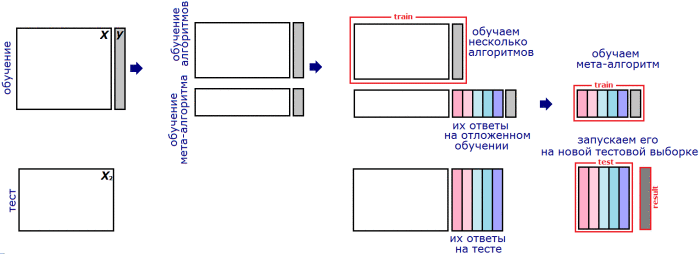

Какие минусы у этого подхода?
- не используется вся выборка для обучения
- не используются исходные признаки
- метапризнаки на обучении и на тесте разные

Как бороться?


- использовать кросс валидацию и увеличение количества базовых естиматоров
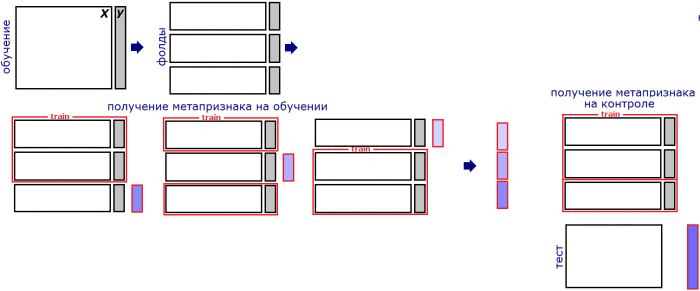

- добавлять исходные признаки вы выборку
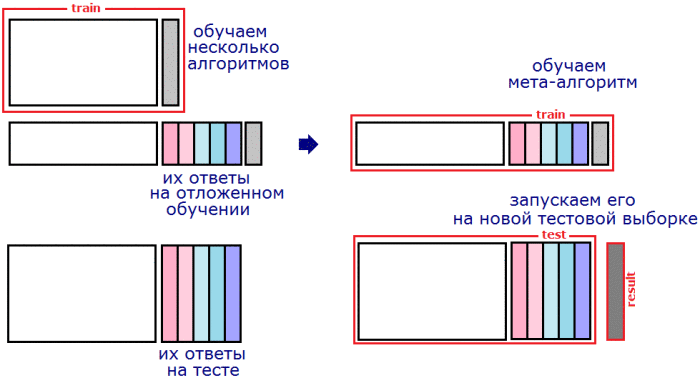
- использовать регуляризацию, а для сложных базовых алгоритмов использовать зашумление метапризнаков
- для метапризнаков исользовать регрессоры (даже в классифкации)
- модификация метапризнаков, например попарные произведения

Хочу поделиться интересной библиотекой для удобного построения ансамблей методов различной сложности: ML-Ensemble (mlens)

In [68]:
from mlens.ensemble import SuperLearner
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [69]:
ensemble = SuperLearner(scorer=skmetrics.accuracy_score, random_state=0, verbose=2)
ensemble.add([SVC(), DecisionTreeClassifier()])
ensemble.add_meta(LogisticRegression())
X_train, X_test, y_train, y_test = train_test_split(samples, targets, test_size=0.25, random_state=0)
ensemble.fit(X_train, y_train)
pred_y = ensemble.predict(X_test)


Fitting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:00

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


In [70]:
print(skmetrics.accuracy_score(y_test, pred_y))
traces = draw_scatter3d(X_test, pred_y)
go.Figure(data=traces)

0.94


## Полезные ссылки

- [Документация sklearn](https://scikit-learn.org/stable/modules/ensemble.html) для реализации ансамблей
- [mlens](http://ml-ensemble.com/info/tutorials/start.html)
- [Алгебраическая](http://www.ccas.ru/frc/papers/zhuravlev78prob33.pdf) подноготная классификации, в том числе и ансаблями. *Только для проженных математиков*
- [Бэггинг и RSM](http://rduin.nl/papers/paa_02_bagging.pdf) - Хорошая статья
- [AdaBoost](https://www.cs.princeton.edu/courses/archive/spr07/cos424/papers/boosting-survey.pdf) - Еще одна статья
- [Модификации AdaBoost](https://cseweb.ucsd.edu/~yfreund/papers/boostingexperiments.pdf)
- [Ещё чуть-чуть про ассамблирование](https://web.engr.oregonstate.edu/~tgd/publications/mcs-ensembles.pdf)
- [Статья про введение в градиентные бустинги](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
- [XGBoost, LightGBM or CatBoost — which boosting algorithm should I use?](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc)
- [Оригинальная статья про сравнение бустингов](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)
- [ODS Тема 10. Градиентный бустинг](https://habr.com/ru/company/ods/blog/327250/#2-gbm-algoritm)
